# Multi Fidelity Batram

This notebook shows how to run the MF-BTM

In [65]:
# Keep this cell while WIP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting Started with Transport Maps

This is our first example getting started with transport maps. It shows how to
fit a transport map to a univariate spatial field, evaluate the fit, and generate
new samples emulating the training data. This is a simple demonstration of the
method published in [1] on a small dataset.

The notebook is separated into the following parts:

- Data loading and visualization
- Data preprocessing
- Fitting a transport map with default optimization settings
- Fitting a transport map with custom optimizers
- Evaluating the fit (checking the optimization)
- Sampling new data
- Scoring new data

References

[1] Katzfuss and Schäfer (2023, JASA). https://doi.org/10.1080/01621459.2023.2197158

In [66]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Packages for data loading
import pathlib
import pickle

# Packages for working with array data and tensors]
import numpy as np
import matplotlib.pyplot as plt
import torch

# Packages for building transport maps
import veccs.orderings
from batram.legmods import SimpleTM

In [67]:
# after the imports set a seed for reproducibility
# anyhow, the results will be different on different machines
# cf. https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(0)
torch.manual_seed(0)


### Data Loading and Inspection

Our model assumes we are loading datasets of the following structure:
- An $N \times d$ array of spatial locations indexing the dataset
- An $n \times N$ array of observations at the $N$ indexed locations

Below we load a test dataset. The data consist of 200 replications of a
spatial field on a 30 x 30 grid over the unit square; i.e., there are $n=200$
samples of a process defined on $(0, 1)^2$ with 30 evenly spaced points in each
dimension.

In [68]:
# Load data and print dimensions
data_fp = pathlib.Path("../tests/data/data_mf.pkl")
with open(data_fp, "rb") as fh:
    data_pkl: dict[str, np.ndarray] = pickle.load(fh)


locs_lf = data_pkl["locs_lf"]
locs_mf = data_pkl["locs_mf"]
locs_hf = data_pkl["locs_hf"]

obs_lf = data_pkl["obs_lf"]
obs_mf = data_pkl["obs_mf"]
obs_hf = data_pkl["obs_hf"]

To get an idea of what the data look like, we plot the first 40 spatial fields for each fidelity: First low fidelity.

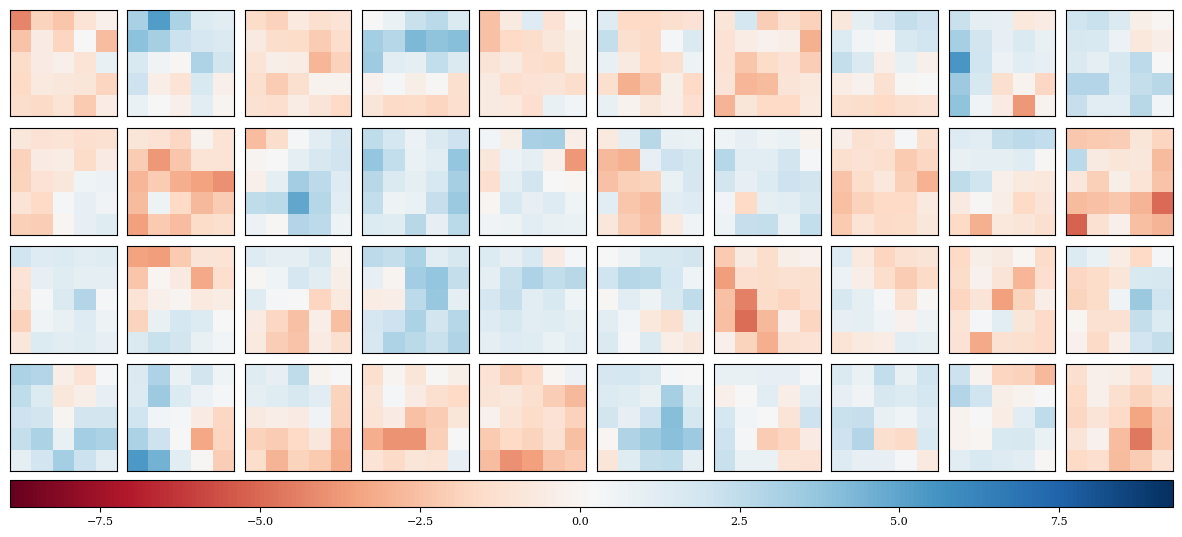

In [69]:
gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
vmin, vmax = obs_hf[:40].min(), obs_hf[:40].max()
plt.set_cmap('RdBu')
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(obs_lf[i].reshape(5, 5), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

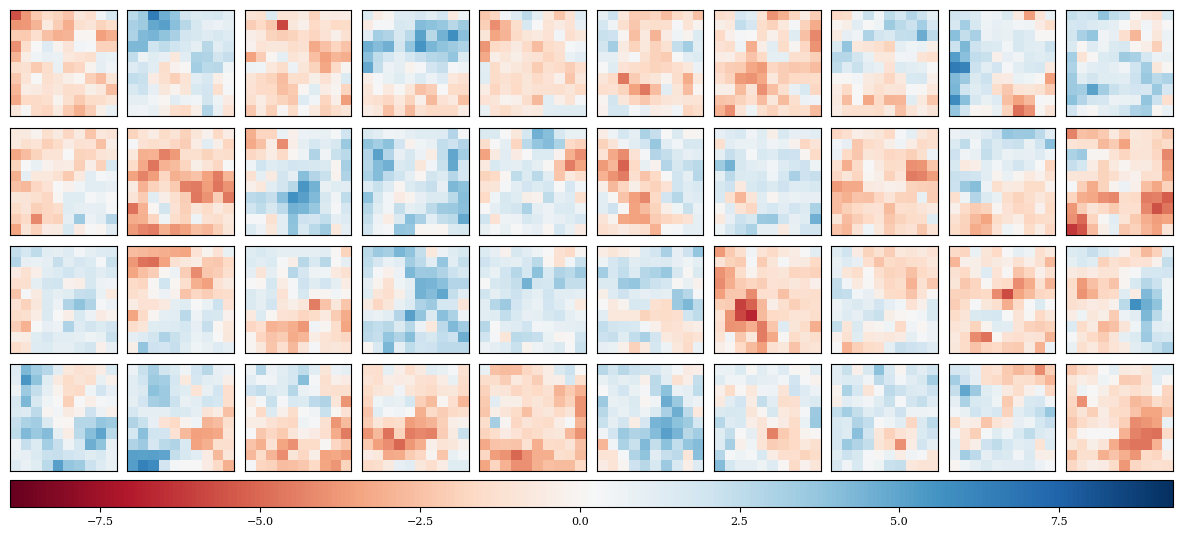

In [70]:
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(obs_mf[i].reshape(10, 10), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

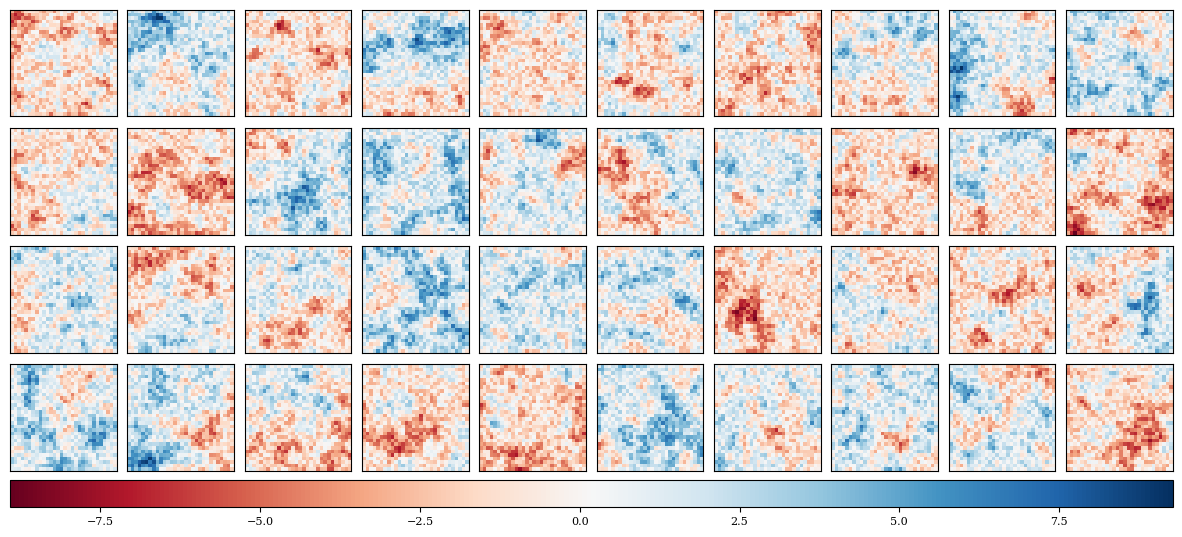

In [71]:
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(obs_hf[i].reshape(30, 30), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

### Data Preprocessing and Map Initialization

Our models assume the data have been pixel-wise centered and an ordering of the
data has been computed. We also require nearest neighbor information to fit the
model. The centering is easy to do using numpy or pytorch arrays, and the `veccs`
package provides the required functionality for the remaining steps. The next
code block demonstrates the typical preprocessing steps, then stores the
transformed data in a `Data` container.

In [72]:
from scipy.spatial.distance import cdist

# Train with first 50 samples
obs_lf_train = obs_lf[:50, :]
obs_mf_train = obs_mf[:50, :]
obs_hf_train = obs_hf[:50, :]

# Used 200-250 as the test set
obs_lf_test = obs_lf[200:250, :]
obs_mf_test = obs_mf[200:250, :]
obs_hf_test = obs_hf[200:250, :]

# Pixel-wise data centering, so that each pixel is mean zero
# variance 1)

mean_lf = obs_lf.mean(dim=0, keepdim = True)
sd_lf = obs_lf.std(dim=0, keepdim= True)
mean_mf = obs_mf.mean(dim=0, keepdim=True)
sd_mf = obs_mf.std(dim = 0, keepdim=True)
mean_hf = obs_hf.mean(dim = 0, keepdim=True)
sd_hf = obs_hf.std(dim=0, keepdim=True)
obs_lf = (obs_lf_train - mean_lf)/sd_lf
obs_mf = (obs_mf_train - mean_mf)/sd_mf
obs_hf = (obs_hf_train - mean_hf)/sd_hf
obs = torch.hstack((obs_lf, obs_mf, obs_hf))

obs_lf_test = (obs_lf_test - mean_lf)/sd_lf
obs_mf_test = (obs_mf_test - mean_mf)/sd_mf
obs_hf_test = (obs_hf_test - mean_hf)/sd_hf
obs_test = torch.hstack((obs_lf_test, obs_mf_test, obs_hf_test))

In [73]:
# add aditional epsilon column to the low-fidelity locations
# to avoid numerical issues (i.e., some length-scales
# being zero) with the transport map. Just pick such that the 
# lengthscales later are decreasing and never zero
dist_mf = cdist(locs_mf, locs_mf)
epsilon_1 = dist_mf[dist_mf!=0.0].min()
epsilon_1_col = torch.zeros(25, 1) + epsilon_1
locs_lf = torch.hstack((locs_lf, epsilon_1_col))
locs_lf.shape

torch.Size([25, 3])

In [74]:
# additonal column for mf locations
dist_hf = cdist(locs_hf, locs_hf)
epsilon_2 = dist_hf[dist_hf!=0.0].min()/3
epsilon_2_col = torch.zeros(100, 1) + epsilon_2
locs_mf = torch.hstack((locs_mf, epsilon_2_col))
locs_mf.shape

torch.Size([100, 3])

In [75]:
locs_hf = torch.hstack((locs_hf, torch.zeros(900,1)))
locs_hf.shape

torch.Size([900, 3])

In [ ]:
# Placeholder cell, to be deleted once the pull request is merged in
# the veccs package

import numpy as np
import scipy.spatial.distance as sdist
from veccs.orderings2 import preceding_neighbors

def find_nns_l2_mf(locs_all: list[np.ndarray], max_nn: int = 10) -> np.ndarray:
    """
    Return an (N, 2·max_nn) array with the indices of the max_nn
    preceding neighbours inside the same fidelity (left block) and inside the
    *previous* fidelity (right block).  Missing neighbours are encoded with –1.
    """
    ns         = np.array([locs.shape[0] for locs in locs_all], dtype=int)
    prefix_sum = np.concatenate(([0], np.cumsum(ns)))          # 0, n₁, n₁+n₂, …

    NN_same  : list[np.ndarray] = []
    NN_prev  : list[np.ndarray] = []

    for r, locs in enumerate(locs_all):
        n_r = ns[r]

        # within-fidelity neighbours 
        NNr, _ = preceding_neighbors(locs, np.arange(n_r), max_nn)
        # shift to global indices, then restore the −1 mask
        NNr = NNr + prefix_sum[r]
        NNr[NNr == prefix_sum[r] - 1] = -1

        # previous fidelity neighbours
        if r == 0:                                     # no previous fidelity
            NN_prev_r = -np.ones((n_r, max_nn), dtype=int)
        else:
            prev_n   = ns[r - 1]
            k        = min(max_nn, prev_n)

            # allocate full (n_r, max_nn) array filled with −1
            NN_prev_r = -np.ones((n_r, max_nn), dtype=int)

            distM = sdist.cdist(locs_all[r], locs_all[r - 1])      # (n_r, prev_n)
            odr   = np.argsort(distM, axis=1)[:, :k]               # (n_r, k)

            NN_prev_r[:, :k] = odr + prefix_sum[r - 1]             # shift to global

        NN_same.append(NNr)
        NN_prev.append(NN_prev_r)

    NN_same  = np.vstack(NN_same)
    NN_prev  = np.vstack(NN_prev)
    NN_all   = np.hstack((NN_same, NN_prev))

    return NN_all


In [98]:
from veccs.orderings import maxmin_pred_cpp

# Maximin ordering of the locations using the `veccs` package for each fidelity
# Note, the locations array is reordered over its first dimension, whereas the
# observations are reordered over the last dimension.
# Also note that veccs functions recieve numpy arrays, using torch arrays 
# sometimes produces bugs.
# 
ord_lfmf = maxmin_pred_cpp(locs_lf.detach().numpy(), locs_mf.detach().numpy())
ord_mf = ord_lfmf[25:125]
ord_lf = ord_lfmf[:25]

# can only order two fidelities at a time using the maximin_pred_cpp function
# so we use this little hack. Easily extendable to more fidelities
locs_lfmf = torch.vstack((locs_lf, locs_mf))
ord_aux = maxmin_pred_cpp(locs_lfmf.detach().numpy(), locs_hf.detach().numpy())
ord_hf = ord_aux[125:]
ord = np.concatenate((ord_lf, ord_mf, ord_hf))

locs = torch.vstack((locs_lf, locs_mf, locs_hf))
locs_ord = locs[ord, ...]
obs_ord = obs[..., ord]
obs_test_ord = obs_test[..., ord]

# Finding nearest neighbors using the `veccs` package.
# For this example let's use 20 max nearest neighbors. 
# For the multifidelity version, pass a list of the ordered locs from
# lowest to highest fidelity
locs_all = [locs_ord[:25].detach().numpy(), locs_ord[25:125].detach().numpy(), locs_ord[125:].detach().numpy()]
largest_conditioning_set = 50
nn = find_nns_l2_mf(locs_all, largest_conditioning_set)

In [99]:
from batram.data import MultiFidelityData, AugmentDataMF

fidelity_sizes = torch.as_tensor(list(map(len, locs_all)))
data = MultiFidelityData.new(locs_ord, obs_ord, torch.as_tensor(nn), fidelity_sizes)
data_augmented = AugmentDataMF()
aug_data = data_augmented(data)
scales = aug_data.scales

In [100]:
scales

tensor([1.0000, 0.7071, 0.7071,  ..., 0.0139, 0.0139, 0.0139])

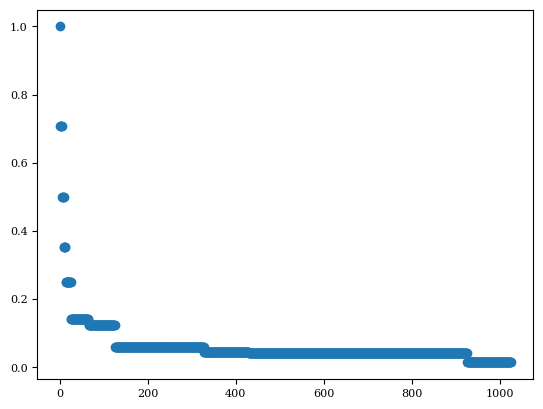

In [101]:
x = range(1, 1026)
plt.scatter(x, scales)

In [102]:
R = 3
theta_init = torch.zeros((9*R-2))
log_2m = data.response[:, 0].square().mean().log()
# Nugget 1
theta_init[:R] = log_2m
# Nugget 2
theta_init[R:2*R] = 0.2
# Sigma 1
theta_init[2*R:3*R] = 0.0
# Sigma 2
theta_init[3*R:4*R] = 0.0
# Theta q 0 within
theta_init[4*R:5*R] = 0.0
# Theta q 1 within
theta_init[5*R:6*R] = 0.0
# Theta q 0 between
theta_init[6*R:7*R-1] = 0.0
# Theta q 1 between
theta_init[7*R-1:8*R-2]
# Theta gammas
theta_init[8*R-2:9*R-2] = -1.0

# Training

We train hyperparameters for each fidelity separately, so you should see $R=3$ progress bars below

In [103]:
from batram.mf import MultiFidelityTM

tm = MultiFidelityTM(data, theta_init, nug_mult = 4.0)
# The `nsteps` argument is always required. When using a user-defined optimizer
# we ignore the initial learning rate. The `batch_size` specifies how to perform
# minibatch gradient descent. The `test_data` argument is optional and is used
# to compute the test loss at each step.
nsteps = 200
opt = torch.optim.Adam(tm.parameters(), lr=0.001)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
res = tm.fit(
    nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched
)

Train Loss: -4427.552, Test Loss: -4427.573: 100%|██████████| 200/200 [02:03<00:00,  1.61it/s]


# Loss

Check out if losses seem to converge, tweak learning rates if not. Note that the losses all fidelities are saved in the same vector, so you have to adapt the script for more fidelities.

C:\Users\Aleja\AppData\Local\Temp\ipykernel_42560\1209856098.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


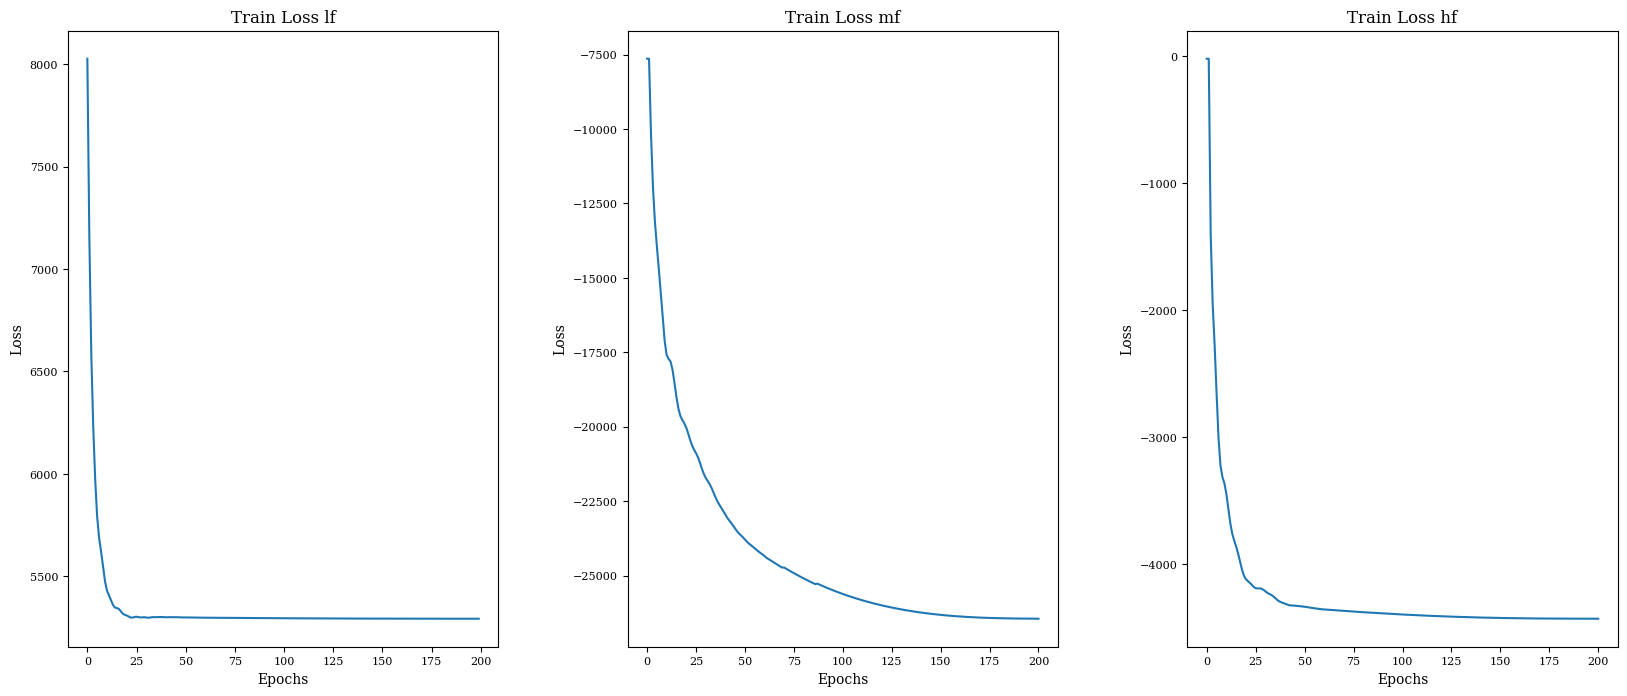

In [104]:
import matplotlib.pyplot as plt

gspec = {"wspace": 0.3, "hspace": 0.1}
fig, ax = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw=gspec)#, squeeze=True)
ax[0].plot(res.losses[1:nsteps+1])
ax[0].set_title('Train Loss lf')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(res.losses[nsteps+1:2*nsteps+2])
ax[1].set_title('Train Loss mf')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

ax[2].plot(res.losses[2*nsteps+2:])
ax[2].set_title('Train Loss hf')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
plt.tight_layout()
plt.show()

# Visualizing the obtained parameters

One check is to just see the raw parameter values and see if the obtained values converge, which they seem to do here. Tweak learning rates as neccessary. Note that all parameters are saved in lists of $niter \times R$, so you have to access them appropriately.

Text(0.5, 1.0, 'High fidelity parameters')

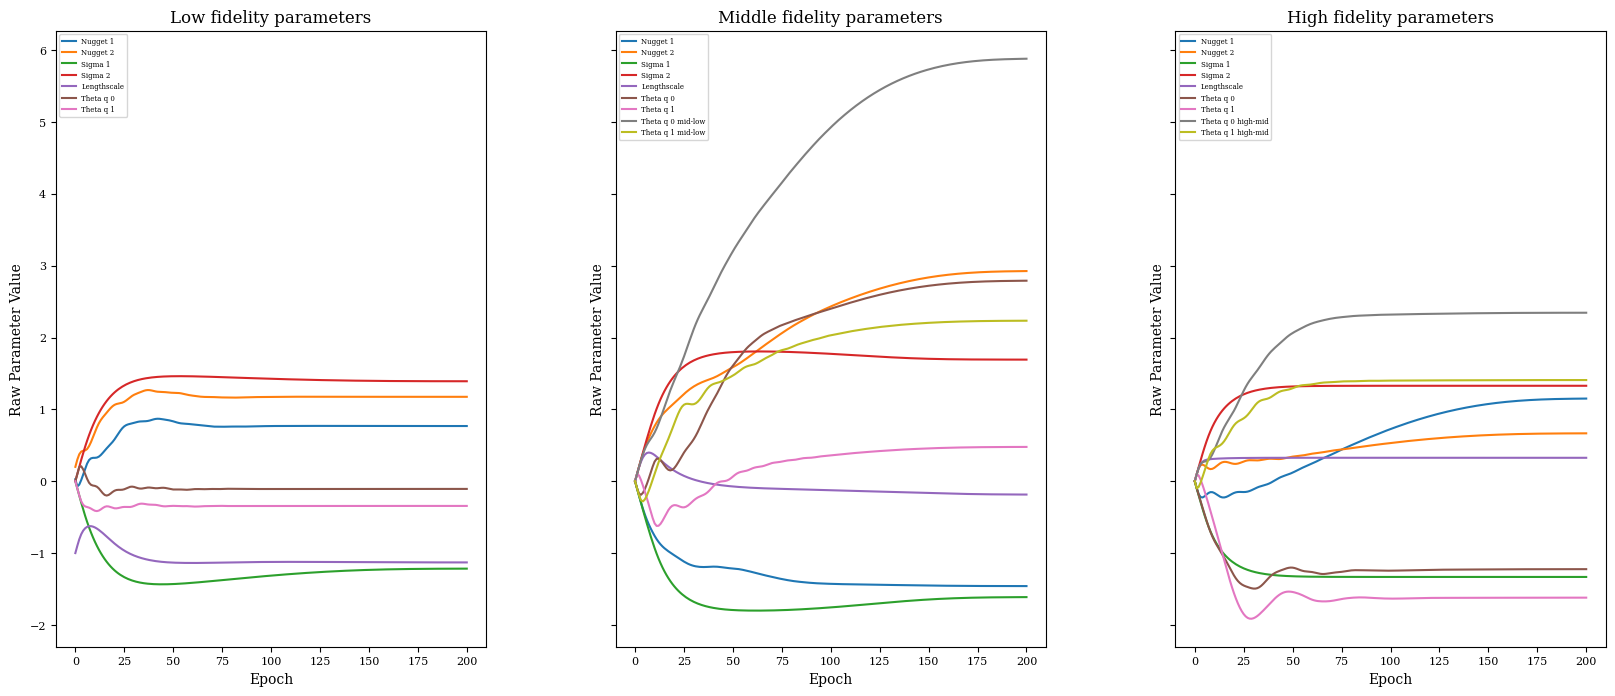

In [105]:

gspec = {"wspace": 0.3, "hspace": 0.1}
fig, ax = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw=gspec, sharey=True)
labels=["Nugget 1", "Nugget 2", "Sigma 1", "Sigma 2", "Lengthscale", "Theta q 0", 
        "Theta q 1"]
to_plot = [res.param_chain["nugget.nugget_params"][:nsteps+1,0], res.param_chain["nugget.nugget_params"][:nsteps+1,3],
           res.param_chain["kernel.sigma_params"][:nsteps+1,0], res.param_chain["kernel.sigma_params"][:nsteps+1,3],
           res.param_chain["kernel.lengthscale"][:nsteps+1,0], res.param_chain["kernel.theta_q"][:nsteps+1,0], 
           res.param_chain["kernel.theta_q"][:nsteps+1,3]]
param_chain = np.vstack(to_plot).transpose()
ax[0].plot(param_chain, label = labels)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Raw Parameter Value")
ax[0].legend(loc=2, prop={'size': 5})
ax[0].set_title('Low fidelity parameters')

labels=["Nugget 1", "Nugget 2", "Sigma 1", "Sigma 2", "Lengthscale", "Theta q 0", 
        "Theta q 1", "Theta q 0 mid-low", "Theta q 1 mid-low"]
to_plot = [res.param_chain["nugget.nugget_params"][nsteps+1:2*nsteps+2,1], res.param_chain["nugget.nugget_params"][nsteps+1:2*nsteps+2,4],
           res.param_chain["kernel.sigma_params"][nsteps+1:2*nsteps+2,1], res.param_chain["kernel.sigma_params"][nsteps+1:2*nsteps+2,4],
           res.param_chain["kernel.lengthscale"][nsteps+1:2*nsteps+2,1], res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,1], 
           res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,4], res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 6],
           res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 8]]
param_chain = np.vstack(to_plot).transpose()
ax[1].plot(param_chain, label = labels)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Raw Parameter Value")
ax[1].legend(loc=2, prop={'size': 5})
ax[1].set_title('Middle fidelity parameters')

labels=["Nugget 1", "Nugget 2", "Sigma 1", "Sigma 2", "Lengthscale", "Theta q 0", 
        "Theta q 1", "Theta q 0 high-mid", "Theta q 1 high-mid"]
to_plot = [res.param_chain["nugget.nugget_params"][2*nsteps+2:,2], res.param_chain["nugget.nugget_params"][2*nsteps+2:,5],
           res.param_chain["kernel.sigma_params"][2*nsteps+2:,2], res.param_chain["kernel.sigma_params"][2*nsteps+2:,5],
           res.param_chain["kernel.lengthscale"][2*nsteps+2:,2], res.param_chain["kernel.theta_q"][2*nsteps+2:,2], 
           res.param_chain["kernel.theta_q"][2*nsteps+2:,5], res.param_chain["kernel.theta_q"][2*nsteps+2:, 7],
           res.param_chain["kernel.theta_q"][2*nsteps+2:, 9]]
param_chain = np.vstack(to_plot).transpose()
ax[2].plot(param_chain, label = labels)
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Raw Parameter Value")
ax[2].legend(loc=2, prop={'size': 5})
ax[2].set_title('High fidelity parameters')

Other idea is to convert them in something more interpretable. We have the $\theta_{\sigma, 1}$ and $\theta_{\sigma, 2}$ parameters which in this implementation become $6$ different parameters, two for each fidelity. We have that $\sigma_i^2 = e^{\theta_{\sigma, 1}} l_i^{\theta_{\sigma_2}}$, and we can do that for each fidelity and plot $\sigma_i$ vs $i$.

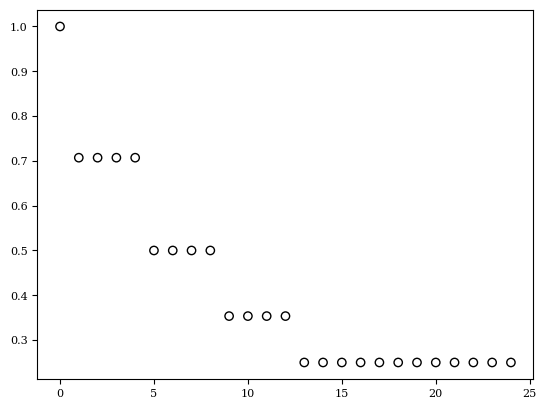

In [106]:
aug_data = tm.augment_data(tm.data)
li_lf = aug_data.scales[0:25]
sigma_i_sq = torch.exp(theta_init[6] + torch.exp(theta_init[9]) * torch.log(li_lf))
x = range(0, 25)
plt.scatter(x, sigma_i_sq.detach().numpy(), facecolors='none', edgecolors='black')

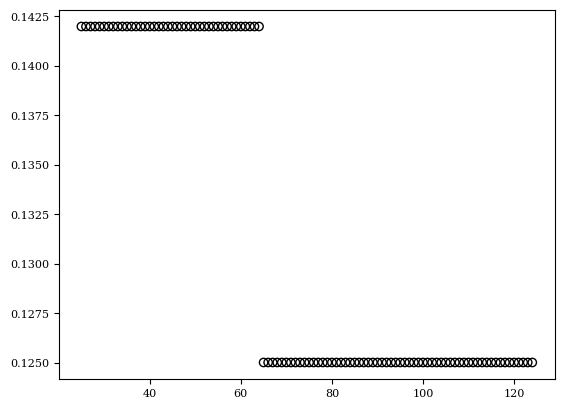

In [107]:
li_mf = aug_data.scales[25:125]
sigma_i_sq = torch.exp(theta_init[7] + torch.exp(theta_init[10]) * torch.log(li_mf))
x = range(25, 125)
plt.scatter(x, sigma_i_sq.detach().numpy(), facecolors='none', edgecolors='black')

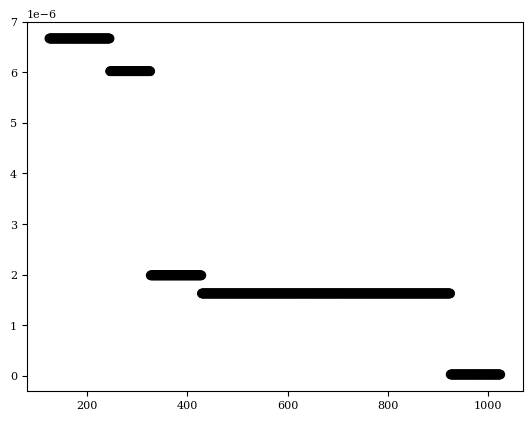

In [108]:
li_hf = aug_data.scales[125:]
sigma_i_sq = torch.exp(theta_init[8] + torch.exp(theta_init[11]) * torch.log(li_hf))
x = range(125, 1025)
plt.scatter(x, sigma_i_sq.detach().numpy(), facecolors='none', edgecolors='black')

# Nearest Neighbors

First the raw parameters, $\theta_{q,0}$ and $\theta_{q,1}$ for each fidelity and between fidelities. By Matthias' and Paul's suggestions, we have scaling to be

$$ exp(\theta_{q,0}^{(r,r)} - \theta_{q,1}^{(r,r)}k) $$

with $k$ is the number of neighbors. For finding neighbors on the previous fidelity

$$ exp(\theta_{q,0}^{(r,r-1)} - \theta_{q,1}^{(r,r-1)}k) $$

Here we observe the number of nearest neighbors within and between fidelities


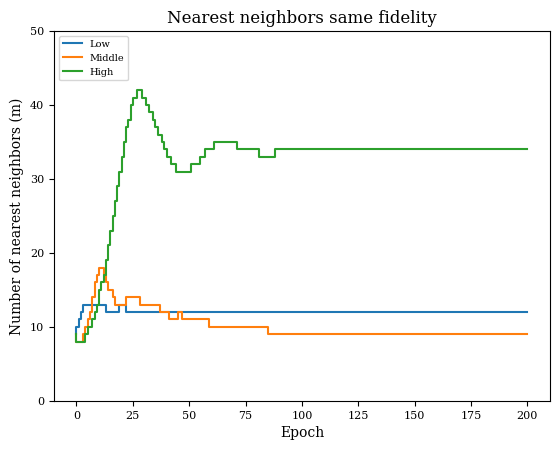

In [109]:
def det_m(max_m, theta_q_0, theta_q_1): 
    rng = torch.arange(max_m) + 1
    scales = scale(theta_q_0, theta_q_1, rng)
    mask = scales >= 0.01
    m = mask.sum()
    return m

def scale(theta_q_0, theta_q_1, k):
    theta_q_1 = torch.exp(theta_q_1)
    return torch.exp(theta_q_0 - 0.5*theta_q_1*k)

ms = []
theta_q_00 = res.param_chain["kernel.theta_q"][:nsteps+1,0] 
theta_q_10 = res.param_chain["kernel.theta_q"][:nsteps+1,3]
theta_q_01 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,1]
theta_q_11 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,4]
theta_q_02 = res.param_chain["kernel.theta_q"][2*nsteps+2:,2]
theta_q_12 = res.param_chain["kernel.theta_q"][2*nsteps+2:,5]
thetas_q_0 = [theta_q_00, theta_q_01, theta_q_02]
thetas_q_1 = [theta_q_10, theta_q_11, theta_q_12]
for i in range(R):
    m = []
    theta_q_0 = thetas_q_0[i]
    theta_q_1 = thetas_q_1[i]
    for j in range(len(theta_q_0)):
        tq0 = torch.tensor(theta_q_0[j])
        tq1 = torch.tensor(theta_q_1[j])
        m1 = det_m(50, tq0, tq1)
        m.append(m1)
    ms.append(m)

_, ax = plt.subplots(1, 1)
epochs = np.arange(len(ms[0]))
labels = ['Low', 'Middle', 'High']
for m, label in zip(ms, labels):
    ax.step(epochs, m, label=label)
ax.set_title("Nearest neighbors same fidelity")
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of nearest neighbors (m)")
ax.set_ylim(0, data.max_m)
ax.legend(loc=2, prop={'size': 7})

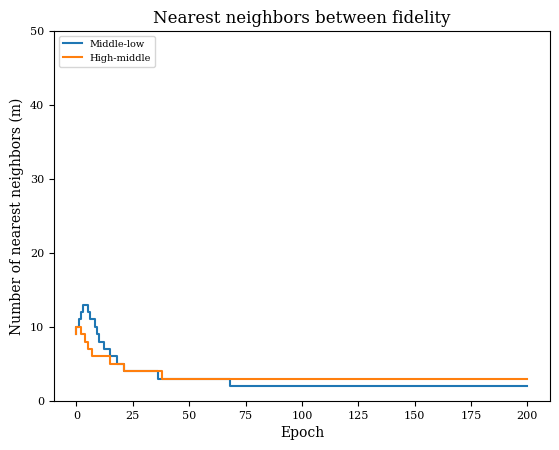

In [110]:
ms = []
theta_q_00 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 6]
theta_q_10 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 8]
theta_q_01 = res.param_chain["kernel.theta_q"][2*nsteps+2:, 7]
theta_q_11 = res.param_chain["kernel.theta_q"][2*nsteps+2:, 9]
thetas_q_0 = [theta_q_00, theta_q_01]
thetas_q_1 = [theta_q_10, theta_q_11]
for i in range(2):
    m = []
    theta_q_0 = thetas_q_0[i]
    theta_q_1 = thetas_q_1[i]
    for j in range(len(theta_q_0)):
        tq0 = torch.tensor(theta_q_0[j])
        tq1 = torch.tensor(theta_q_1[j])
        m2 = det_m(50, tq0, tq1)
        m.append(m2)
    ms.append(m)

_, ax = plt.subplots(1, 1)
epochs = np.arange(len(ms[0]))
labels = ['Middle-low', 'High-middle']
for m, label in zip(ms, labels):
    ax.step(epochs, m, label=label)
ax.set_title("Nearest neighbors between fidelity")
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of nearest neighbors (m)")
ax.set_ylim(0, data.max_m)
ax.legend(loc=2, prop={'size': 7})

# Sampling

In [111]:
import matplotlib.pyplot as plt

# Set global font size and style
plt.rc('font', size=10)  # Default font size for text
plt.rc('axes', titlesize=12)  # Font size for axes titles
plt.rc('axes', labelsize=10)  # Font size for x and y labels
plt.rc('xtick', labelsize=8)  # Font size for x-tick labels
plt.rc('ytick', labelsize=8)  # Font size for y-tick labels
plt.rc('legend', fontsize=9)  # Font size for legend
plt.rc('figure', titlesize=12)  # Font size for figure titles

# Optional: Set font family
plt.rc('font', family='serif')  # e.g., Times New Roman for a consistent style

In [112]:
obs = obs_test_ord[4]
true_lf_1 = obs[0:25][ord_lf.argsort()]*sd_lf + mean_lf
true_mf_1 = obs[25:125][ord_mf.argsort()]*sd_mf + mean_mf
true_hf_1 = obs[125:][ord_hf.argsort()]*sd_hf + mean_hf

obs = obs_test_ord[5]
true_lf_2 = obs[0:25][ord_lf.argsort()]*sd_lf + mean_lf
true_mf_2 = obs[25:125][ord_mf.argsort()]*sd_mf + mean_mf
true_hf_2 = obs[125:][ord_hf.argsort()]*sd_hf + mean_hf

In [113]:
# Observations
obs1 = obs_test_ord[4]
obs2 = obs_test_ord[5]

true_lf_1 = obs1[0:25][ord_lf.argsort()]*sd_lf + mean_lf
true_mf_1 = obs1[25:125][ord_mf.argsort()]*sd_mf + mean_mf  
true_hf_1 = obs1[125:][ord_hf.argsort()]*sd_hf + mean_hf

true_lf_2 = obs2[0:25][ord_lf.argsort()]*sd_lf + mean_lf
true_mf_2 = obs2[25:125][ord_mf.argsort()]*sd_mf + mean_mf  
true_hf_2 = obs2[125:][ord_hf.argsort()]*sd_hf + mean_hf

# Sample conditional on mf
sample = tm.cond_sample(obs2, 2)
sample_cond_mf = sample[0]
sample_cond_mf_hf = sample_cond_mf[125:][ord_hf.argsort()]*sd_hf + mean_hf

# Sample conditional on lf
sample = tm.cond_sample(obs2, 1)
sample_cond_lf = sample[0]
sample_cond_lf_mf = sample_cond_lf[25:125][ord_mf.argsort()]*sd_mf + mean_mf
sample_cond_lf_hf = sample_cond_lf[125:][ord_hf.argsort()]*sd_hf + mean_hf

# Sample unconditional
sample = tm.cond_sample(obs2, 0)
sample_uncond = sample[0]

sample_uncond_lf = sample_uncond[0:25][ord_lf.argsort()]*sd_lf + mean_lf
sample_uncond_mf = sample_uncond[25:125][ord_mf.argsort()]*sd_mf + mean_mf
sample_uncond_hf = sample_uncond[125:][ord_hf.argsort()]*sd_hf + mean_hf

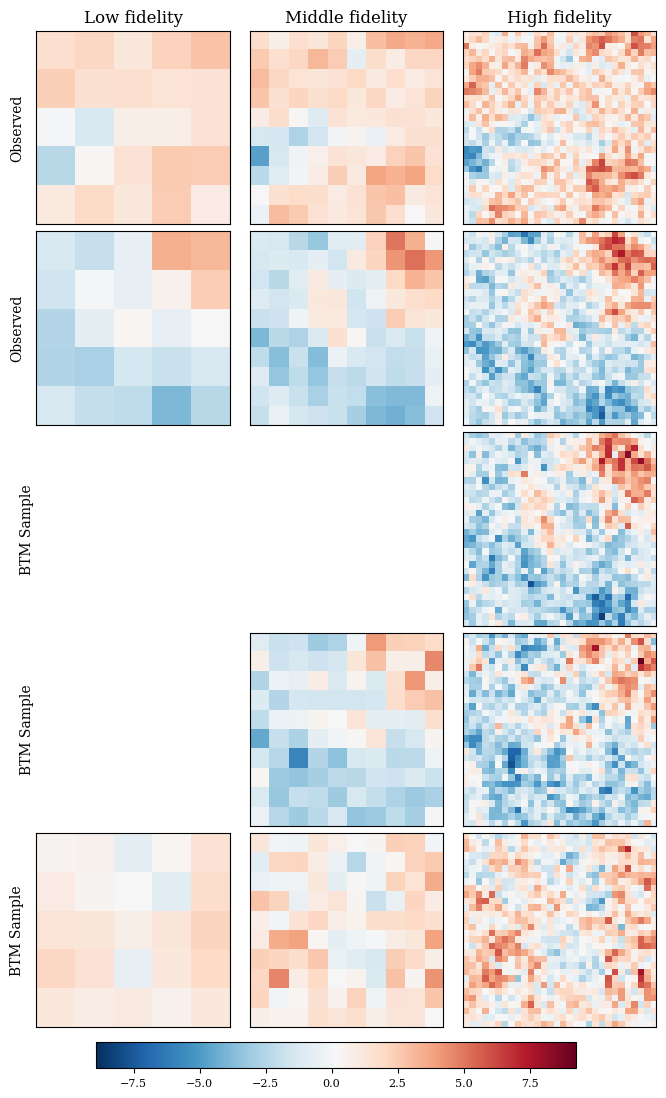

In [114]:
#gspec = {"wspace": 0.1, "hspace": 0.5}
cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under(color='lightgrey')
fig, ax = plt.subplots(5, 3, figsize=(8, 13))# gridspec_kw=gspec, squeeze=True)
plt.subplots_adjust(wspace=0.1, hspace=0.01)
#fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02)

# Observed fields
ax[0,0].imshow(true_lf_1.reshape(5, 5), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title("Low fidelity")
ax[0,0].text(-0.1, 0.5, 'Observed', rotation=90, va='center', ha='center', transform=ax[0,0].transAxes)

im = ax[0,1].imshow(true_mf_1.reshape(10,10), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title("Middle fidelity")

im = ax[0,2].imshow(true_hf_1.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
ax[0,2].set_title("High fidelity")

ax[1,0].imshow(true_lf_2.reshape(5, 5), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].text(-0.1, 0.5, 'Observed', rotation=90, va='center', ha='center', transform=ax[1,0].transAxes)

im = ax[1,1].imshow(true_mf_2.reshape(10,10), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
#ax[1,1].text(-0.1, 0.5, 'Observed', rotation=90, va='center', ha='center', transform=ax[1,1].transAxes)

im = ax[1,2].imshow(true_hf_2.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
#ax[1,2].set_title("True High fidelity")

# Samples from BTM model
ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_frame_on(False)
ax[2,0].text(-0.05, 0.5, 'BTM Sample', rotation=90, va='center', ha='center', transform=ax[2,0].transAxes)

ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].set_frame_on(False)

ax[2,2].imshow(sample_cond_mf_hf.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[2,2].set_xticks([])
ax[2,2].set_yticks([])

ax[3,0].set_xticks([])
ax[3,0].set_yticks([])
ax[3,0].set_frame_on(False)
ax[3,0].text(-0.05, 0.5, 'BTM Sample', rotation=90, va='center', ha='center', transform=ax[3,0].transAxes)

im = ax[3,1].imshow(sample_cond_lf_mf.reshape(10, 10), vmin=vmin, vmax=vmax, cmap=cmap)
ax[3,1].set_xticks([])
ax[3,1].set_yticks([])

im = ax[3,2].imshow(sample_cond_lf_hf.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[3,2].set_xticks([])
ax[3,2].set_yticks([])

im = ax[4,0].imshow(sample_uncond_lf.reshape(5, 5), vmin=vmin, vmax=vmax, cmap=cmap)
ax[4,0].set_xticks([])
ax[4,0].set_yticks([]) 
ax[4,0].text(-0.1, 0.5, 'BTM Sample', rotation=90, va='center', ha='center', transform=ax[4,0].transAxes)

ax[4,1].imshow(sample_uncond_mf.reshape(10, 10), vmin=vmin, vmax=vmax, cmap=cmap)
ax[4,1].set_xticks([])
ax[4,1].set_yticks([])

im = ax[4,2].imshow(sample_uncond_hf.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[4,2].set_xticks([])
ax[4,2].set_yticks([])

cbar = fig.add_axes([0.2, 0.08, 0.6, 0.02]) 
fig.colorbar(im, cax=cbar, orientation="horizontal")
#OUTPUT_FILE = "./results/figs/samples_all.pdf"
#DPI = 500  # Specify the DPI
#fig.savefig(OUTPUT_FILE, format='pdf', dpi=DPI, bbox_inches='tight')

# Scores

The score_new function gives scores per pixel, you have to aggregate them

In [115]:
# Unconditional score
tm.score(obs_test_ord[19], 0)

tensor(751.9936)

In [116]:
# Conditional score on low fidelity
tm.score(obs_test_ord[19], 1)

tensor(727.8806)

In [117]:
# Conditional score on low and middle fidelities
tm.score(obs_test_ord[19], 2)

tensor(669.7443)